# Land Cover classification with U-Net (multi-class semantic segmentation)


## Table of Content

- [Load project](#1)
- [Load packages](#2)
- [Load dataset](#3)
- [Dataset description](#4)
- [Preprocessing](#5)
- [Class distribution of the training data and visualizations](#6)
- [Model](#7)
- [Confusion matrix](#8)

<a name='1'></a>
## Load project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = '/content/drive/My Drive/SegmentationProject'
os.chdir(path)

In [ ]:
!git clone https://github.com/ShayaKahn/Satellite-Image-Segmentation.git

Cloning into 'Satellite-Image-Segmentation'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 72 (delta 27), reused 65 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 6.35 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [3]:
%cd Satellite-Image-Segmentation

/content/drive/My Drive/SegmentationProject/Satellite-Image-Segmentation


<a name='2'></a>
### Load packages

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import imageio
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from src.utils import get_image_mask_list, sort_image_mask_lists, display_image_mask, create_confusion_matrix
from src.preprocessing import preprocess_pipeline, split, Augment, modify_mask, one_hot
from src.model import UnetModel, DiceLoss, JaccardLoss, CombinedLoss, MeanIoU

<a name='3'></a>
## Load dataset

In [5]:
# Create image and mask lists with the corresponding order
path = '/content/drive/My Drive/SegmentationProject/raw_data'
os.chdir(path)

image_list, mask_list = get_image_mask_list(path)
image_list_sorted, mask_list_sorted = sort_image_mask_lists(image_list, mask_list)

Text(0.5, 1.0, 'Segmentation')

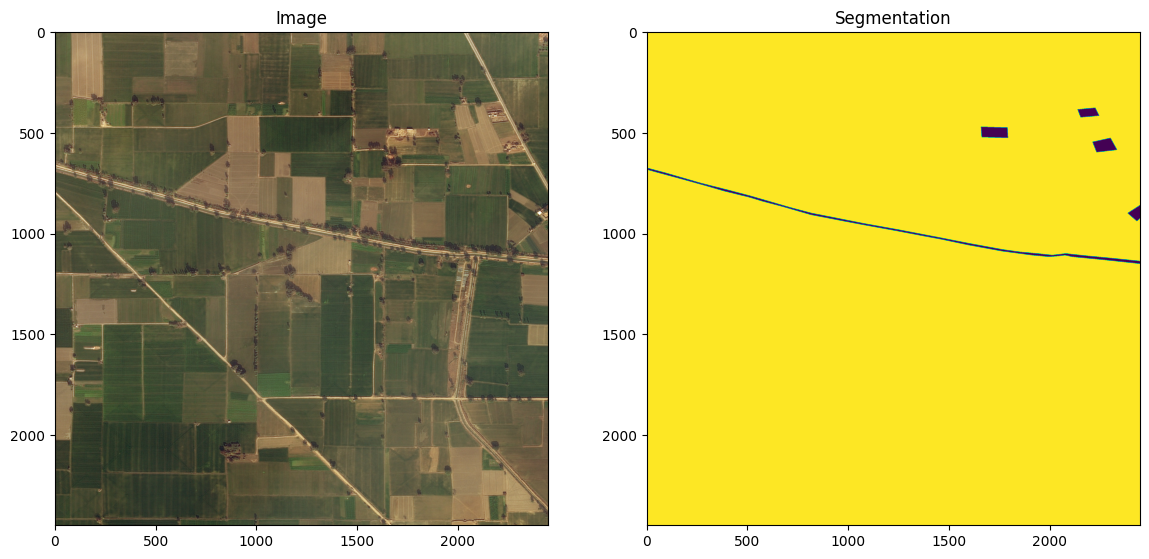

In [ ]:
# Visualize example of image and mask
ind = 2
img = imageio.imread(image_list_sorted[ind])
mask = imageio.imread(mask_list_sorted[ind])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='4'></a>
### Dataset description
The dataset consists of 803 satellite images and the corresponding masks (lables). The lables defined as follows:

In [ ]:
# Show the different lables
data = {
    'r': [0, 255, 255, 0, 0, 255, 0],
    'g': [255, 255, 0, 255, 0, 255, 0],
    'b': [255, 0, 255, 0, 255, 255, 0],
    'Color': ['Cyan', 'Yellow', 'Magenta', 'Green', 'Blue', 'White', 'Black'],
}

titles = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land',
          'water', 'barren_land', 'unknown']

df = pd.DataFrame(data, index=titles)

# Function to calculate luminance
def calculate_luminance(r, g, b):
    return 0.299 * r + 0.587 * g + 0.114 * b

# Custom function to set the background and text color based on RGB values
def highlight_row(row):
    r, g, b = row['r'], row['g'], row['b']
    hex_color = f'#{r:02x}{g:02x}{b:02x}'

    luminance = calculate_luminance(r, g, b)
    text_color = 'black' if luminance > 128 else 'white'

    return [f'background-color: {hex_color}; color: {text_color}'] * len(row)

styled_df = df.style.apply(highlight_row, axis=1) \
    .set_properties(**{'text-align': 'center', 'font-size': '12pt',
                       'width': '80px'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align',
                                                             'center')]},
        {'selector': 'td:hover', 'props': [('background-color', '#ffff99')]},
    ])

styled_df

,r,g,b,Color
urban_land,0,255,255,Cyan
agriculture_land,255,255,0,Yellow
rangeland,255,0,255,Magenta
forest_land,0,255,0,Green
water,0,0,255,Blue
barren_land,255,255,255,White
unknown,0,0,0,Black


<a name='5'></a>
## Preprocessing

In [6]:
# Apply preprocessing
processed_image_ds = preprocess_pipeline(image_list_sorted, mask_list_sorted,
                                         divide=False)

In [7]:
# Split to train, validation and test sets
train_dataset, val_dataset, test_dataset, train_size, val_size = split(
    train_frac=0.7, val_frac=0.15, dataset=processed_image_ds)

In [8]:
# Increase the size of the training dataset using data augmentation
tf.random.set_seed(1234)

size=256
num = 0
crop_height, crop_width, target_height, target_width = 192, 192, size, size

train_dataset_augmented = train_dataset

for _ in range(num):
    seed = int((tf.random.uniform(shape=(), minval=0,
                             maxval=1000, dtype=tf.int32).numpy()))
    augmented_dataset = train_dataset.map(Augment(seed, crop_height, crop_width,
                                                  target_height, target_width))
    train_dataset_augmented = train_dataset_augmented.concatenate(
        augmented_dataset)

In [9]:
# Apply one hot encoding
train_dataset_augmented = train_dataset_augmented.map(modify_mask).map(one_hot)
val_dataset = val_dataset.map(modify_mask).map(one_hot)
test_dataset = test_dataset.map(modify_mask).map(one_hot)

<a name='6'></a>
## Class distribution of the training data and visualizations

In [ ]:
# Show the class distribution
dist = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

for img, mask in train_dataset:
    mask_numpy = mask.numpy().squeeze()
    unique_values, counts = np.unique(mask_numpy, return_counts=True)
    for val, count in zip(unique_values, counts):
        dist[val] += count

In [ ]:
classes = {0: 'unknown', 1:'forest_land', 2:'agriculture_land', 3:'water',
           4:'rangeland', 5:'urban_land', 6:'barren_land'}

keys = list(dist.keys())
values = list(dist.values())

# Map keys to class names
keys = [classes[key] for key in keys]

plt.figure(figsize=(10, 6))

plt.bar(keys, values, color='skyblue')

plt.xlabel('Keys')
plt.ylabel('Counts')
plt.title('Class distribution')

plt.show()

In [10]:
train_dataset_augmented = train_dataset_augmented.cache().prefetch(
    tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

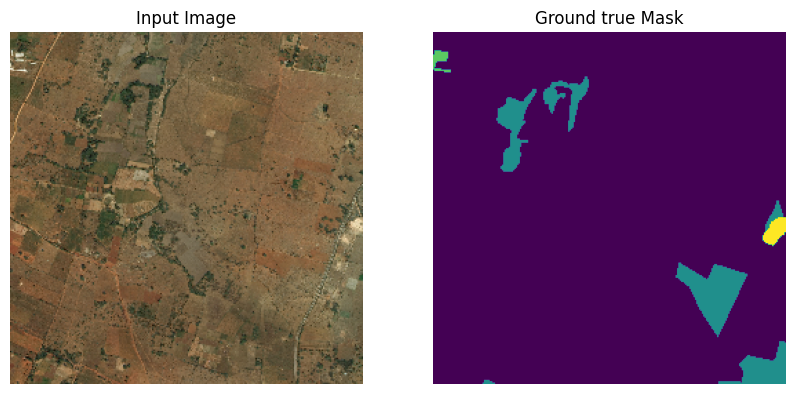

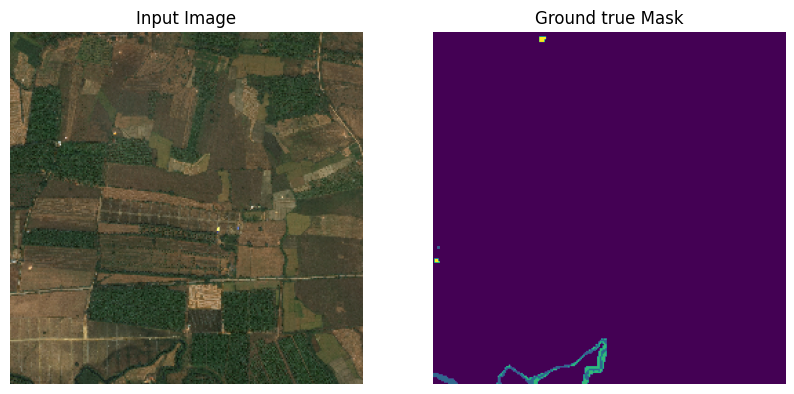

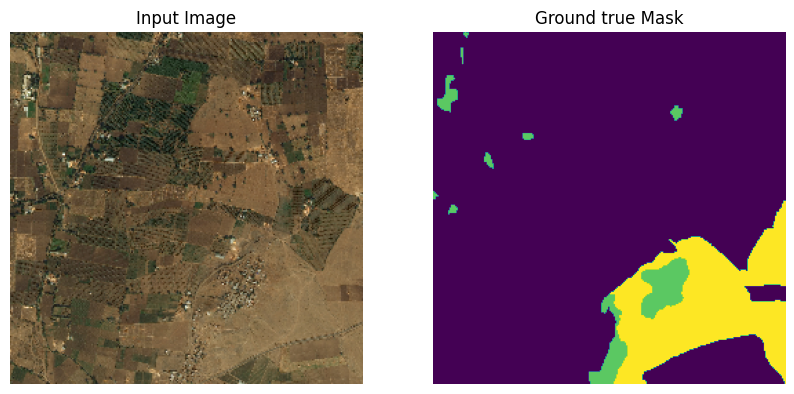

In [65]:
# Show several examples of the training data after preprocessing
for image, mask in train_dataset_augmented.take(3):
    sample_image, sample_mask = image, mask
    sample_mask = tf.argmax(sample_mask, axis=-1).numpy().reshape(size,size,1)
    display_image_mask([sample_image, sample_mask])

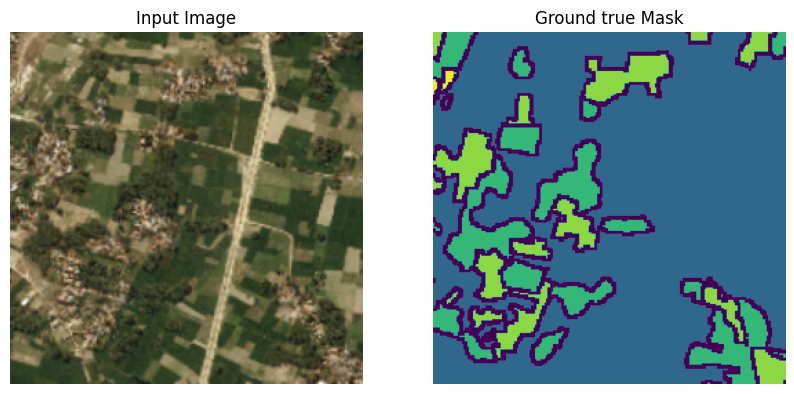

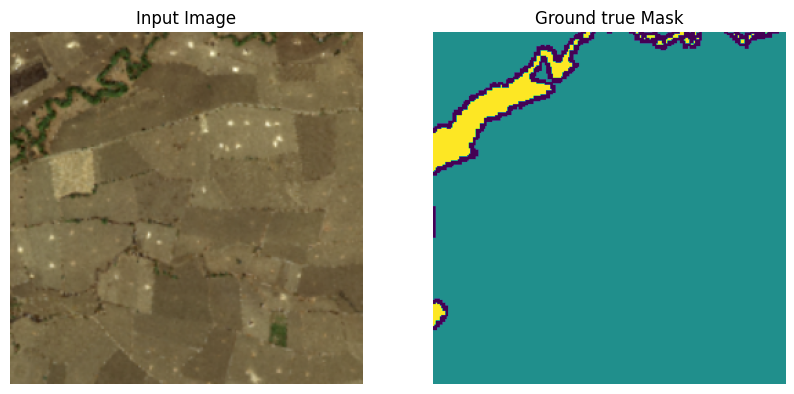

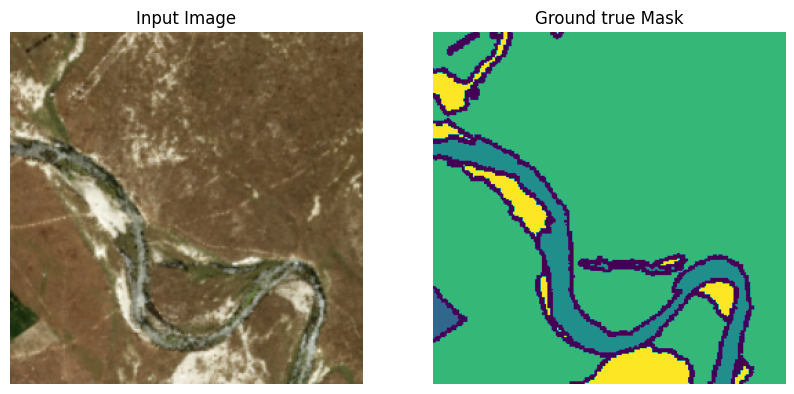

In [ ]:
# Show augmented images and masks
for image, mask in train_dataset_augmented.skip(train_size).take(3):
    sample_image, sample_mask = image, mask
    sample_mask = tf.argmax(sample_mask, axis=-1).numpy().reshape(size,size,1)
    display_image_mask([sample_image, sample_mask])

In [11]:
# Shuffle the data after augmentation
BUFFER_SIZE = 500

train_dataset_augmented = train_dataset_augmented.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)

In [12]:
BATCH_SIZE = 32

train_dataset_augmented = train_dataset_augmented.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

<a name='7'></a>
## Model

In [13]:
# Create the U-net model
img_height = size
img_width = size
num_channels = 3
n_filters = 32
dropout_prob = 0.3
max_pooling = False
kernel_size = 3
n_classes = 7

unet = UnetModel(n_filters, dropout_prob, max_pooling, kernel_size,
                 input_size=(size, size, num_channels), n_classes=n_classes)

unet_model = unet.call()
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 512)    │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 7,671,911 (29.27 MB)

 Trainable params: 7,671,911 (29.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define loss functions
dice = DiceLoss(from_logits=True)
dice_weighted = DiceLoss(from_logits=True, use_class_weights=True)
jaccard = JaccardLoss(from_logits=True)
jaccard_weighted = JaccardLoss(from_logits=True, use_class_weights=True)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
dice_cce = CombinedLoss(dice, cce)
jaccard_cce = CombinedLoss(jaccard, cce)
dice_cce_weighted = CombinedLoss(dice_weighted, cce)
jaccard_cce_weighted = CombinedLoss(jaccard_weighted, cce)

In [15]:
# Compile the model
unet_model.compile(optimizer='adam', loss=dice_cce,
                   metrics=['accuracy', MeanIoU(num_classes=7)])

Train the model and save the weights

In [25]:
# Train the model
tf.test.gpu_device_name()

EPOCHS = 15

#checkpoint_path = '/content/drive/My Drive/SegmentationProject/training.weights.h5'
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

with tf.device('/device:GPU:0'):
    model_history = unet_model.fit(train_dataset_augmented, epochs=EPOCHS,
                                   validation_data=val_dataset)#,
                                   #callbacks=[cp_callback])

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 686ms/step - accuracy: 0.8803 - loss: 0.3435 - mean_io_u: 0.6917 - val_accuracy: 0.8278 - val_loss: 0.4927 - val_mean_io_u: 0.5428
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 660ms/step - accuracy: 0.8846 - loss: 0.3376 - mean_io_u: 0.6741 - val_accuracy: 0.8223 - val_loss: 0.4904 - val_mean_io_u: 0.5494
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - accuracy: 0.8879 - loss: 0.3314 - mean_io_u: 0.7132 - val_accuracy: 0.8279 - val_loss: 0.5201 - val_mean_io_u: 0.5333
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 629ms/step - accuracy: 0.8947 - loss: 0.3189 - mean_io_u: 0.7144 - val_accuracy: 0.8269 - val_loss: 0.5031 - val_mean_io_u: 0.5512
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 657ms/step - accuracy: 0.8924 - loss: 0.3103 - mean_io_u: 0.7442 - val_accuracy: 0.8296 - val_loss: 0.4979 - val_mean_io_u: 0.5557
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.9045 - loss: 0.2987 - mean_io_u: 0.7327 - val_accuracy: 0.8231 - val

Train the model with the saved weights

In [17]:

# Load the saved weights
#checkpoint_path = '/content/drive/My Drive/SegmentationProject/training.weights.h5'
#unet_model.load_weights(checkpoint_path)


# Continue training the model
#with tf.device('/device:GPU:0'):
#    model_history = unet_model.fit(train_dataset_augmented, epochs=EPOCHS,
#                                   validation_data=val_dataset)

In [26]:
# Evaluate the model on the test set
unet_model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.8011 - loss: 0.6118 - mean_io_u: 0.4952


[0.5978678464889526, 0.8042332530021667, 0.5106604099273682]

In [27]:
# Show several predictions
predictions = unet_model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step


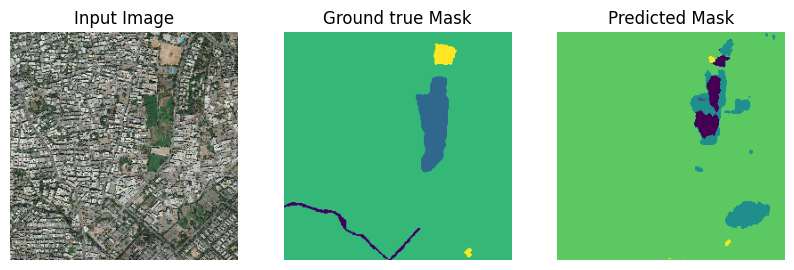

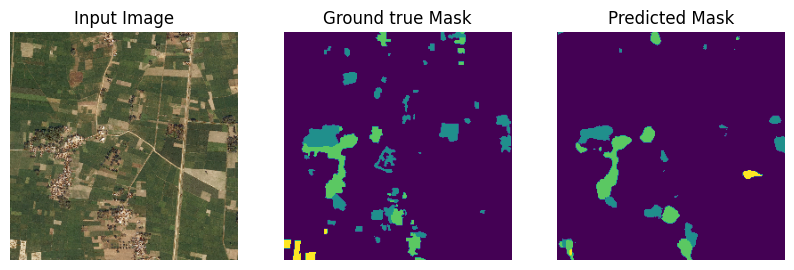

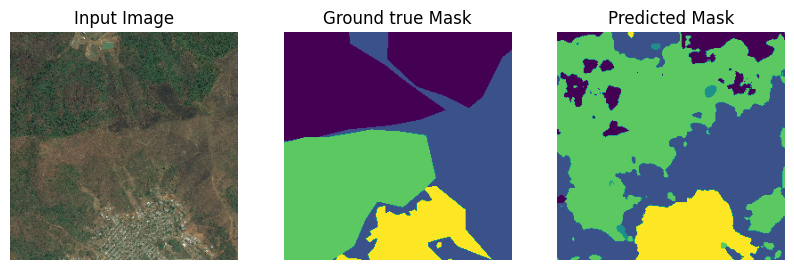

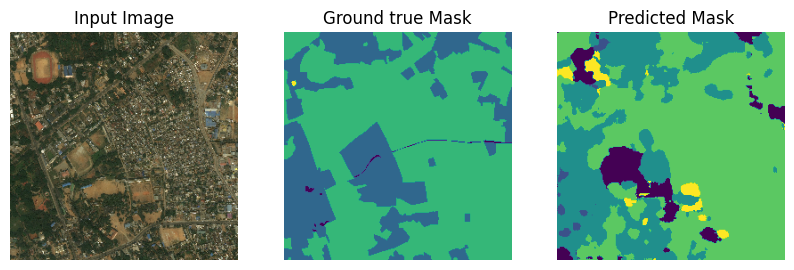

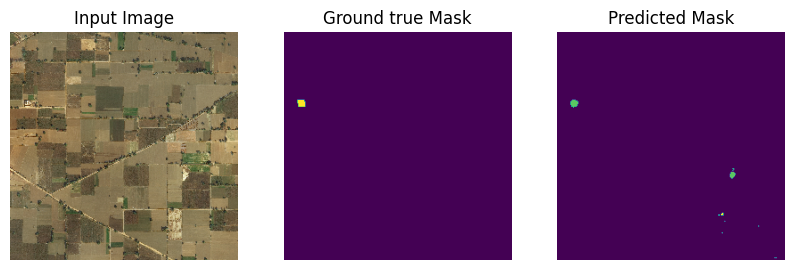

In [28]:
for i, (img, mask) in enumerate(test_dataset.unbatch().take(5)):
    display_image_mask([img, np.argmax(mask, -1)[..., np.newaxis],
                        np.argmax(predictions[i], -1)[..., np.newaxis]])

<a name='7'></a>
## Confusion matrix

In [64]:
labels_lst = []
for element in test_dataset:
    _ , labels = element
    labels_lst.append(labels)

labels_lst_unstack = []
for element in labels_lst:
    labels_lst_unstack += tf.unstack(element, axis=0)

real_mask_lst = [l.numpy().squeeze() for l in labels_lst_unstack]
pred_mask_lst = [p for p in np.eye(7)[np.argmax(predictions, axis=-1)]]

cm = create_confusion_matrix(real_mask_lst, pred_mask_lst, 7)

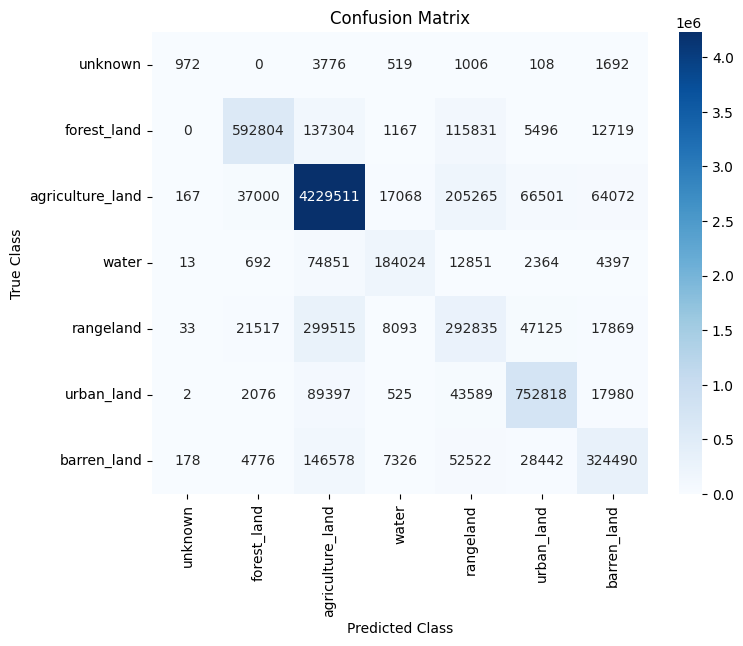

In [62]:
classes = {0: 'unknown', 1:'forest_land', 2:'agriculture_land', 3:'water',
           4:'rangeland', 5:'urban_land', 6:'barren_land'}

class_labels = list(classes.values())

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

plt.show()

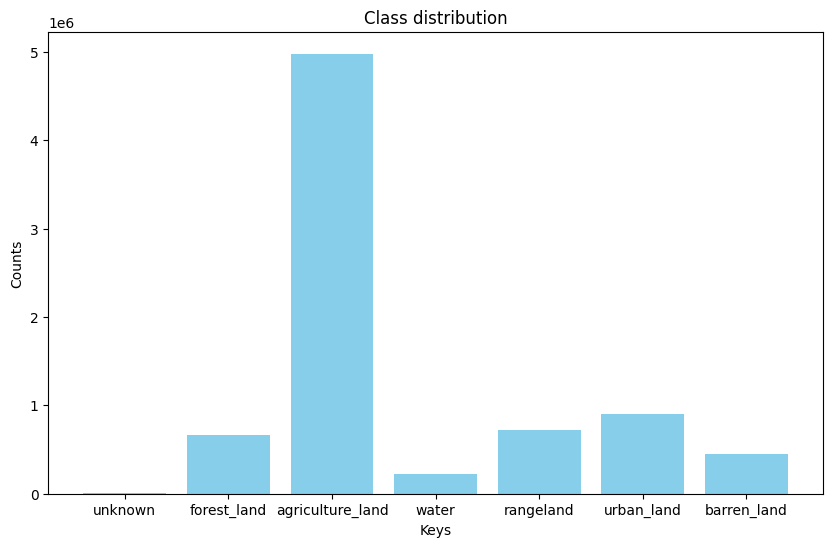

In [63]:
# Show the predicted class distribution
dist = {0: cm[:, 0].sum(), 1: cm[:, 1].sum(), 2: cm[:, 2].sum(),
        3: cm[:, 3].sum(), 4: cm[:, 4].sum(), 5: cm[:, 5].sum(),
        6: cm[:, 6].sum()}

classes = {0: 'unknown', 1:'forest_land', 2:'agriculture_land', 3:'water',
           4:'rangeland', 5:'urban_land', 6:'barren_land'}

keys = list(dist.keys())
values = list(dist.values())

# Map keys to class names
keys = [classes[key] for key in keys]

plt.figure(figsize=(10, 6))

plt.bar(keys, values, color='skyblue')

plt.xlabel('Keys')
plt.ylabel('Counts')
plt.title('Class distribution')

plt.show()